In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

import SweetSpotPrediction as ssp

# 03 Exploration of models
Try out a few models see which one works
*Note: Run 01 to build the .csv files needed*

In [2]:
df = pd.read_csv('ClassificationData.csv')

In [3]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro',
    'NetPerm',

]

label_cls = 'WellPresent' 

In [4]:
df.dropna(inplace=True)

In [5]:
X_train, X_, y_train, y_ = train_test_split(df[features], df[label_cls], test_size=0.33, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)

# Normalization and other preprocessing

In [6]:
preprocessing = StandardScaler()
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)
X_val = preprocessing.transform(X_val)
X_train[:5]

array([[-1.12575556,  0.6153493 , -0.31663338, -1.66260359, -0.82918996],
       [ 0.40753906,  0.25875761, -0.21976436, -0.09182623, -0.33758253],
       [ 1.85501255,  0.31995338, -0.27835758, -0.11918309,  0.12937766],
       [-0.2260377 ,  0.55406095, -0.3504782 ,  0.46813745, -0.41576113],
       [ 1.02251528, -0.07085826,  0.23406518,  0.4761513 ,  4.59688932]])

In [7]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
    
classifiers = [
    AdaBoostClassifier(),
    DecisionTreeClassifier(class_weight='balanced'),
    GradientBoostingClassifier(),
    GaussianNB(),
    KNeighborsClassifier(2),
    #NuSVC(probability=True),
    LinearDiscriminantAnalysis(),
    MLPClassifier(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(),
    SVC(kernel="rbf", C=0.025, probability=True),
    ]

In [8]:
for index, clf in enumerate(classifiers):
    print(f"Model {index}: {clf}")
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    ssp.ReportMetrics(clf, X_train, X_val, y_train, y_val, y_pred_val)
    print(f"-------------------------------------------------------------------")

Model 0: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Weighted accuracy on training set: 0.523
Weighted accuracy on test set: 0.539

Precision: 0.550
Recall: 0.081
F1: 0.141
-------------------------------------------------------------------
Model 1: DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Weighted accuracy on training set: 1.000
Weighted accuracy on test set: 0.748

Precision: 0.534
Recall: 0.522
F1: 0.528
-------------------------------------------------------------------
Model 2: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', m

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Weighted accuracy on training set: 0.675
Weighted accuracy on test set: 0.686

Precision: 0.667
Recall: 0.382
F1: 0.486
-------------------------------------------------------------------
Model 7: QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)
Weighted accuracy on training set: 0.731
Weighted accuracy on test set: 0.719

Precision: 0.109
Recall: 0.824
F1: 0.193
-------------------------------------------------------------------
Model 8: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Weighted accuracy on training set: 0.968
Weig

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


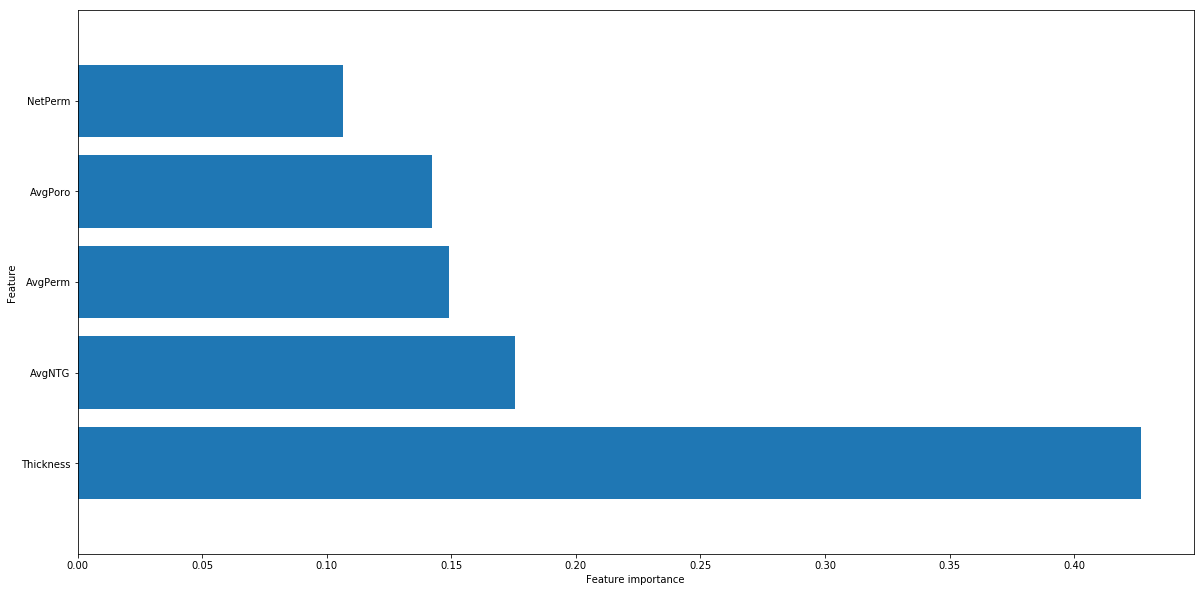

In [9]:
bestModel = classifiers[1]
ssp.plot_feature_importances(bestModel,features)

# <a href="02 Base Model.ipynb">Previous</a> <a href="04 Classification model.ipynb">Next</a> Notebook